# Problem Set: Risk Measures with Stochastic Volatility Models

## Introduction

In this problem set, you will implement and compare two different approaches for estimating financial risk measures:

1. Kalman Filter with Maximum Likelihood Estimation (MLE)
2. EGARCH model

You will use these methods to compute two important risk metrics:
- Value-at-Risk (VaR)
- Expected Shortfall (ES)


## Learning Objectives

- Understand how to implement a Kalman Filter for stochastic volatility models
- Apply Maximum Likelihood Estimation (MLE) for parameter optimization
- Compare the Kalman Filter approach with EGARCH models
- Implement and interpret Value-at-Risk (VaR) and Expected Shortfall (ES)
- Assess model performance using coverage ratio analysis

## Requirements

The following libraries are needed for this problem set:

In [3]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm
from arch import arch_model

## Part 1: Simulate Data from a Stochastic Volatility Model

We'll start by generating simulated data from a stochastic volatility (SV) model. This will allow us to evaluate the performance of our estimation methods against known "ground truth" parameters.

### Task 1.0 Model Specification

Write down the data generating process (DGP) for the SV model we'll use here (use the notation from lecture):


Define every symbol that shows up in the DGP:

### Task 1.1: Simulate SV data

Simulate data from an SV model that fullfils the following specifications:

(a) set the seed to 1234

(b) use a sample size of 2500

(c) model parameters: 0.95 for volatility persistence; 0.2 for "vol of vol"; set the unconditional vol to 1.0. 

(d) initialize the very first element of the latent vol process with its unconditional distribution (see lecture)

(e) plot the simulated return series

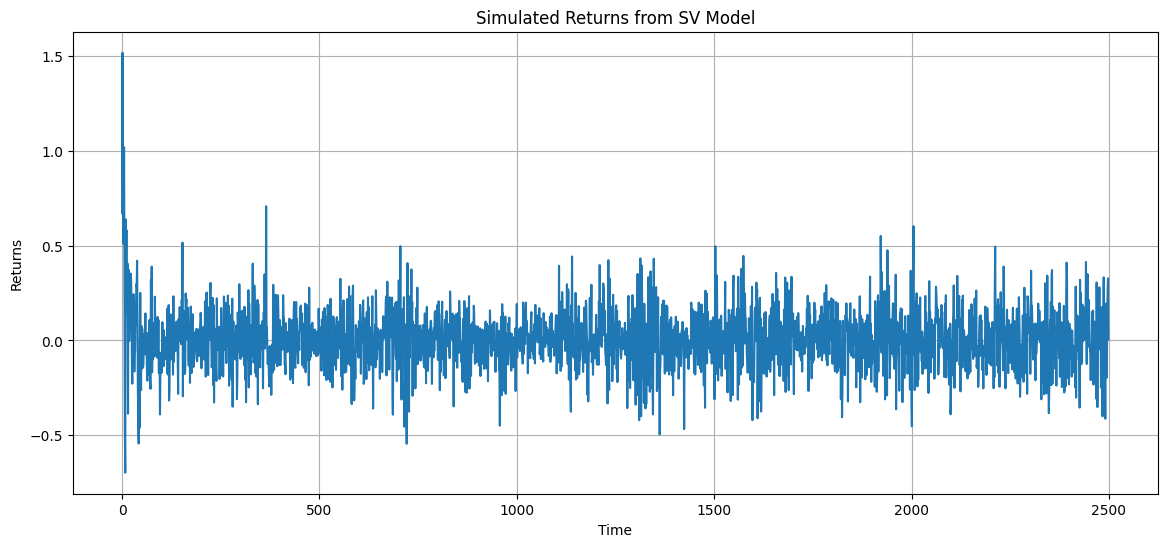

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Fix seed for our test-case
np.random.seed(1234)
T = 2500

# Define SV parameters
volatility_persistence= 0.95
vol_vol = 0.2
vol = - (vol_vol ** 2) / (2 * (1 - volatility_persistence ** 2))

# Array for hidden volatility values (log-volatility)
h_true = np.zeros(T)

# Start from the stationary distribution of the AR(1)
h_true[0] = np.random.normal(loc=vol, scale=vol_vol / np.sqrt(1 - volatility_persistence ** 2))

for t in range(1, T):
    h_true[t] = vol + volatility_persistence * h_true[t - 1] + np.random.normal(0, vol_vol)

# Returns (mean zero)

xi = np.random.normal(0, 1, T)
r = np.exp(0.5 * h_true) * xi

# Plot the simulated returns
plt.figure(figsize=(14, 6))
plt.plot(r)
plt.title('Simulated Returns from SV Model')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.grid(True)
plt.show()

## Part 2: Kalman Filter Implementation

To estimate the SV model, we need to linearize it first using the Harvey Transform.

### Task 2.0 The Harvey Transform

Explain step by step the Harvey transform and state the transformed DGP (see lecture).

### Task 2.1: Implement the Kalman Filter

Implement the Kalman filter estimation routine using the following specification:

(a) function is called kalman_filter. its input is (y, a, B, Phi, H, Q, a1, P1, return_loglike=False) (notation follows lecture). its output is the negative log-likelihood if return_loglike=True and the time series for [posterior mean, posterior variance, prior mean, prior variance] if return_loglike=False. 



In [7]:
def kalman_filter(y, a, B, Phi, H, Q, a1, P1, return_loglike=False):

    T = len(y)

    # Output arrays
    filtered_means = np.zeros(T)
    filtered_vars = np.zeros(T)
    prior_means = np.zeros(T)
    prior_vars = np.zeros(T)

    prior_means[0] = a1
    prior_vars[0] = P1

    # Initialize likelihood function
    log_likelihood = 0

    for t in range(T):

        # Prediction error variance
        F_t = B * prior_vars[t] * B + H

        # Kalman gain
        K_t = (prior_vars[t] * B) / F_t

        # Prediction error
        v_t = y[t] - (a + B * prior_means[t])

        # Update log_likelihood function
        log_likelihood += -0.5 * (np.log(2 * np.pi) + np.log(F_t) + (v_t ** 2) / F_t)

        # Update and store posterior means and variances
        filtered_means[t] = prior_means[t] + K_t * v_t
        filtered_vars[t] = prior_vars[t] *  (1 - K_t * B)

        # Update time, if it is not final step
        if t < T - 1:
            prior_means[t + 1] = Phi * filtered_means[t]
            prior_vars[t + 1] = (Phi**2) * filtered_vars[t] + Q


    if return_loglike:
        return -log_likelihood
    else:
        return filtered_means, filtered_vars, prior_means, prior_vars
